In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

# **What is Time Series?**

Time Series is a set of observations on the values that a variable takes at different times. For example: Sales Trend, Stock Market Price, Weather Forecast etc.
Time Series is using to predict the future values based on the previous obseved value.

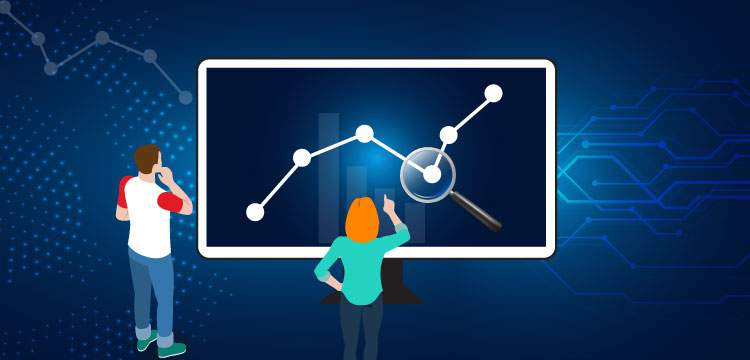

# **Component of Time Series**

* Trend : Tend may show the growth or decline in a time series over a long period. This is the type of tendency which continues to persist for a very long period. Prices and export and import data, for example, reflect obviously increasing tendencies over time.
* Seasonality : These are short term movements occurring in data due to seasonal factors. The short term is generally considered as a period in which changes occur in a time series with variations in weather or festivities
* Irregularity : These are sudden changes occurring in a time series which are unlikely to be repeated. They are components of a time series which cannot be explained by trends, seasonal or cyclic movements. These variations are sometimes called residual or random components.
* Cyclic : These are long term oscillations occurring in a time series. These oscillations are mostly observed in economics data and the periods of such oscillations are generally extended from five to twelve years or more. These oscillations are associated with the well known business cycles. 



# **What is ARIMA model?**

ARIMA stands for Auto Regressive Integrated Moving Average. There are seasonal and Non-seasonal ARIMA models that can be used for forecasting
An ARIMA model is characterized by 3 terms: p, d, q
where p is the order of the AR term, q is the order of the MA term and d is the number of differencing required to make the time series stationary.
If a time series, has seasonal patterns, then you need to add seasonal terms and it becomes SARIMA, short for ‘Seasonal ARIMA’. More on that once we finish ARIMA.

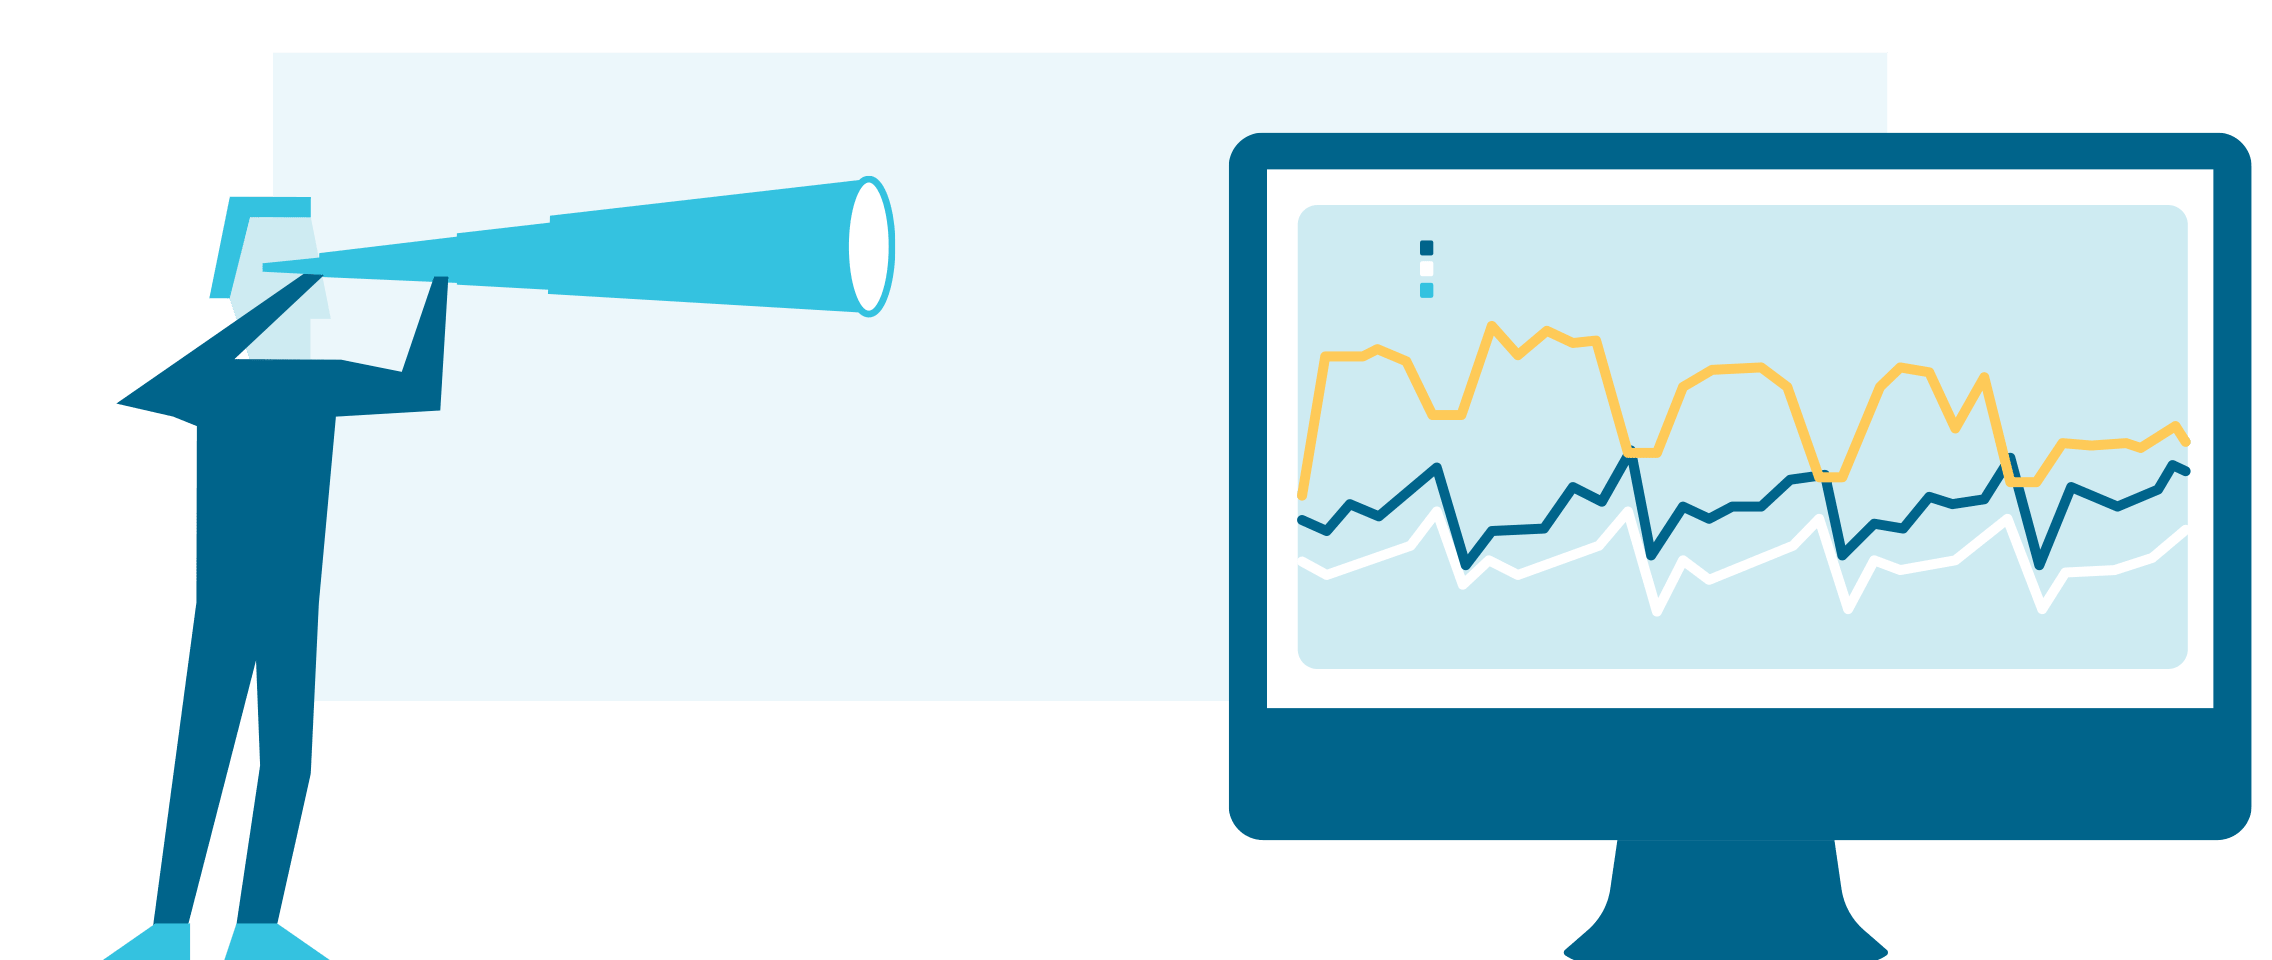

let’s get our environment ready with the libraries we’ll need and then import the data!

In [ ]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib
plt.style.use('ggplot')
import warnings
import itertools
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

Check out the Data

In [ ]:
df = pd.read_csv('/kaggle/input/accident_UK.csv')
df.head()

In [ ]:
df.info()

Convert the Date column to Date type

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.head()

Sorting the data by Date

In [ ]:
df = df.sort_values(by=['Date'])
df.head()

In [ ]:
df.info()

Set the Date for index

In [ ]:
accident = df.set_index('Date')
accident.index

Let's extract the average number of accident in each month

In [ ]:
y = accident['Total_Accident'].resample('MS').mean()
y.head()

Let's visualise the number of accident in each year

In [ ]:
y.plot(figsize=(15, 6))
plt.show()

Let's visualise the data using time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

In [ ]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 16, 10
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

This step is parameter Selection for our ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_invertibility=False)

            results = mod.fit()
            
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

The above output suggests that SARIMAX (1, 1, 1)x(1, 1, 1, 12) yields the lowest AIC value of 289.92. Therefore we should consider this to be optimal option.

**Fitting the ARIMA model**

In [ ]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

We need to always run model diagnostics to investigate any unusual behavior.

In [ ]:
results.plot_diagnostics()
plt.show()

**Evaluation of Forecasts**

In odrer to understand the accuracy of our forecasts, we compare predicted number of accident to real number of accidents of the time series, and we set forecasts to start at 2017–01–01 to the end of the data.

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

Let's find out the MSE to see the accuracy of our model. 
The mean squared error (MSE) is largely used as a metric to determine the performance of an algorithm. In addition, MSE is the average of the square of the difference between the observed and predicted values of a variable.

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

**Visualising Forecasts**

As we can see in the below graph the number of road accident in UK will be declined in next years

In [ ]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

# **What is Prophet ?**

Prophet is an open source Time Series Forecasting Algorithm from Facebook and it designed for ease of use without expert knowledge on Time Series Forecasting or Statistics. Time Series Forecasting builds model by finding a best smooth line which can be represented as sum of the following component:
* Overal Growth Trend
* early Seasonality
* Weekly Seasonality 
* Holiday Affects

Benefit of Prophet Approach:
* Uneven time interval between data is not a problem
* Day with NA is not a problem
* Seasonality with multiple periods (Week & Year) is handled by default
* Works well by default setting, parameters are easily interpretable

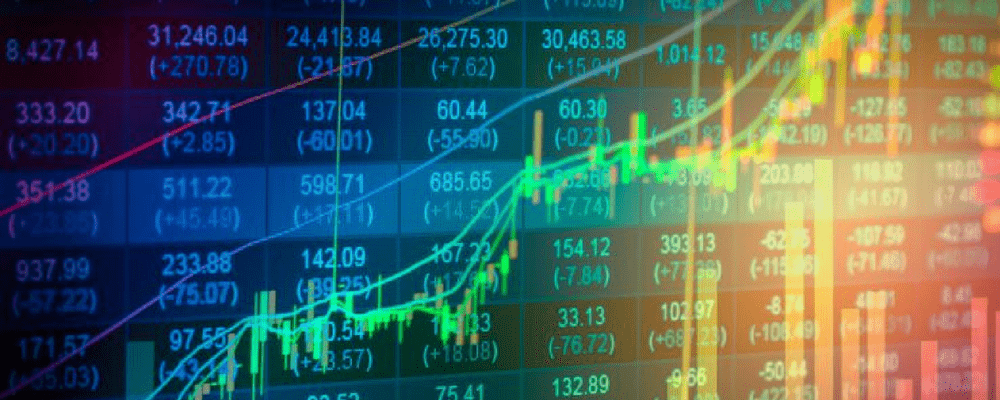

Let's sort the values by Date

In [ ]:
df = df.sort_values(by=['Date'])
df.head()

Prophet requires the variable names in the time series to be:
* y – Target
* ds – Datetime

So, the next step is to convert the dataframe according to the above specifications

In [ ]:
df = df.rename(columns={'Date': 'ds',
                        'Total_Accident': 'y'})
df.head()

Let’s visualise the number of road accident for each day

In [ ]:
ax = df.set_index('ds').plot(figsize=(15, 8))
ax.set_ylabel('Total Accident')
ax.set_xlabel('Date')

plt.show()

**Fitting the Prophet model**

set the uncertainty interval to 95% (the Prophet default is 80%)

In [ ]:
from fbprophet import Prophet
my_model = Prophet(interval_width=0.95)
my_model.fit(df)

To create a forecast with our model we need to create some futue dates. Prophet provides us with a helper function called make_future_dataframe. We pass in the number of future periods and frequency. Above we created a forecast for the next 36 month or 3 years.

In [ ]:
future_dates = my_model.make_future_dataframe(periods=36, freq='MS')
future_dates.tail()

As we can see in the below table. yhat is our forcasted value

In [ ]:
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

Let's create a graph of our actuals and forecast

In [ ]:
pd.plotting.register_matplotlib_converters()
my_model.plot(forecast, uncertainty=True)

plot_components provides us a graph of our trend and seasonality

In [ ]:
my_model.plot_components(forecast)

In [ ]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(my_model, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()

In [ ]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

# **Please Upvote ! If you find this notebook is useful!**

# Many Thanks !

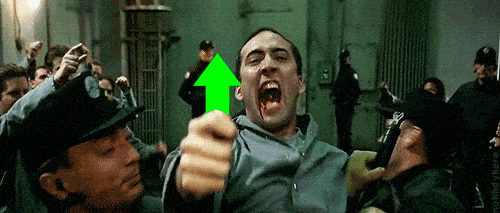